# Part 5: Data-driven model of battery with eDMDc

While the previous data-driven model of the battery created with augmented states in DMDc provided good predictive capabilities, there is room for further improvement. Here we explore the extended DMDc method and demonstrate how to incoporate the trained model in Collimator.

## Dataset
We utilise the same dataset as in the previous tutorial. We also resample the dataset at a frequency of 10Hz.

## Extended Dynamic Mode Decomposition with control (eDMDc)

Unlike, the previous example where we had to invent relevant features to augment the state with, in eDMDc such features can be created by using known basis functions. For example, if our state is $\mathbf{x}\in \mathbb{R}^n$, a Gaussian basis function with center $\mathbf{c}\in \mathbb{R}^n$, can be of the form

$$
\phi(\mathbf{x, \mathbf{c}}) = \exp \left(  - \frac{||\mathbf{x}-\mathbf{c}||^2} {2 \sigma^2}   \right),
$$

where the parameter $\sigma$ is related to the width of the Gaussian kernel.

By specifying the type and number of basis fucntions to use, one can create a rich basis. For example, using two basis functions of the above type, we would seek to find a dynamics model of the following form:


\begin{align}
\begin{pmatrix}
v_t[k+1] \\ d[k+1] \\ \phi_1[k+1] \\ \phi_2[k+1]
\end{pmatrix} = 
A 
\begin{pmatrix}
v_t[k] \\ d[k]  \\ \phi_1[k] \\ \phi_2[k]
\end{pmatrix} +
B
\left( i[k] \right),
\end{align},

where $\phi_1$ and $\phi_2$ are Gaussian kernels. The parameters of the basis functions, $\sigma$ and $\mathbf{c}$, can be provided by the user or estimated by the training algorithm. In what follows, $\sigma$ will be user provided, and the centers $\mathbf{c}$ will be uniformly distributed within the training data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

from math import ceil

from jax import config

config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp

from scipy.io import loadmat

train_file_name = "dataset_25deg/10-28-18_17.44 551_UDDS_25degC_LGHG2.mat"
val_file_name = "dataset_25deg/10-29-18_14.41 551_Mixed1_25degC_LGHG2.mat"

tain_data = loadmat(train_file_name)
val_data = loadmat(val_file_name)

Q = 3.0  # battery capacity is known to be 3Ah (LG HG2 cell)


def extract_features_from_matfile(filename, Q=3.0, dt=0.1):
    data = loadmat(filename)
    t = data["meas"][0][0][0]
    vt = data["meas"][0][0][2]
    curr = -data["meas"][0][0][3]
    D = -data["meas"][0][0][4]

    # Resample
    T_end = t[-1, 0]
    t_resampled = np.linspace(0.0, T_end, ceil(T_end / dt))
    vt_resampled = np.interp(t_resampled, t[:, 0], vt[:, 0])
    curr_resampled = np.interp(t_resampled, t[:, 0], curr[:, 0])
    D_resampled = np.interp(t_resampled, t[:, 0], D[:, 0])

    return (t_resampled, vt_resampled, curr_resampled, D_resampled)


t_train, vt_train, curr_train, d_train = extract_features_from_matfile(train_file_name)
t_val, vt_val, curr_val, d_val = extract_features_from_matfile(val_file_name)

We can write a custom function to compute the centers and the augmented features with the Gaussian kernels.

In [2]:
def get_centers(x, n_centers):
    """
    Obtain uniformly distributed centers in the [min, max] range of
    each input feature.
    
    Args:
        x (ndarray): shape (n_input_features, n_samples)
        n_centers (int): number of uniformly distributed centres
        
    Returns:
        centers (ndarray): shape (n_centers, n_input_features)
        The uniformly distributed centers within the range of each input feature.
    """
    n_input_features, n_samples = x.shape
    
    # Initialize the centers array
    centers = np.zeros((n_centers, n_input_features))
    
    for i in range(n_input_features):
        # Get the minimum and maximum value of the current feature
        min_val = np.min(x[i, :])
        max_val = np.max(x[i, :])
        
        # Generate uniformly spaced values within this range
        centers[:, i] = np.linspace(min_val, max_val, n_centers)
    
    return centers


def compute_augmented_features(x, centers, sigma=1.0/np.sqrt(2)):
    """
    Compute the Gaussian kernel features    
    Args:
        x (ndarray): shape (n_input_features, n_samples)
        centers (ndarray): shape (n_centers, n_input_features)
        sigma (float):
        

    Returns (ndarray):
    Gaussian kernel features of shape (n_centers, n_samples)
    """
    assert x.shape[0] == centers.shape[1]

    n_centers, n_input_features = centers.shape
    
    n_samples = x.shape[1] if x.ndim == 2 else 1

    output_features = np.zeros((n_centers, n_samples))

    for idx, center in enumerate(centers):
        r_squared = np.sum((x.T - center[np.newaxis, :]) ** 2, axis=1)
        output_features[idx, :] = np.exp(-r_squared/(2.0*sigma**2))

    return output_features if x.ndim==2 else output_features[:,0]

In [3]:
state_names = ["$v_t$", "$d$"]

state_data = np.vstack([vt_train, d_train])
control_data = curr_train.reshape((1, curr_train.size))

centers = get_centers(state_data, 10)
gaussian_features = compute_augmented_features(state_data, centers)

augmented_state_data = np.vstack([state_data, gaussian_features])

We use the `compute_dmdc_matrices` from the previous notebook, and modify the `simulate_dmdc` function to account for the kernel augmentation.

In [4]:
def compute_dmdc_matrices(X, X_prime, U):
    # Perform SVD on the data matrix
    Omega = np.vstack((X, U))
    U_omega, Sigma_omega, V_omega = np.linalg.svd(Omega, full_matrices=False)

    # Truncate to rank-r (optional, here we keep all components)
    r = min(Sigma_omega.size, Omega.shape[0], Omega.shape[1])
    U_omega_r = U_omega[:, :r]
    Sigma_omega_r = np.diag(Sigma_omega[:r])
    V_omega_r = V_omega[:r, :]

    # Compute A and B
    A_tilde = X_prime @ V_omega_r.T @ np.linalg.inv(Sigma_omega_r) @ U_omega_r[:X.shape[0], :].T
    B_tilde = X_prime @ V_omega_r.T @ np.linalg.inv(Sigma_omega_r) @ U_omega_r[X.shape[0]:, :].T

    return A_tilde, B_tilde


def simulate_edmdc(A, B, centers, initial_state, U):
    n_states = initial_state.shape[0]
    n_samples = U.shape[1]
    
    # Initialize the state trajectory matrix
    X_sim = np.zeros((n_states, n_samples + 1))
    X_sim[:, 0] = initial_state
    
    # Simulate the system dynamics
    for k in range(n_samples):
        X_aug = np.hstack([X_sim[:,k], compute_augmented_features(X_sim[:,k], centers)])
        X_aug_propagated = A @ X_aug + B @ U[:, k]
        X_sim[:, k + 1] = X_aug_propagated[:n_states]
    return X_sim

In [5]:
X = augmented_state_data[:, :-1]  # State at time k
X_prime = augmented_state_data[:, 1:]  # State at time k+1
U = control_data[:, :-1]  # Control input at time k

# Compute A and B matrices
Aest, Best = compute_dmdc_matrices(X, X_prime, U)

print("Estimated A and B matrices:")
print("A matrix:")
print(Aest)

print("B matrix:")
print(Best)

Estimated A and B matrices:
A matrix:
[[ 9.98626613e-01  2.84853848e-03  3.10383607e+01 -1.25623801e+02
   2.73918807e+02 -4.21866294e+02  5.05738381e+02 -4.89566868e+02
   3.82880275e+02 -2.33438009e+02  1.00760366e+02 -2.34851014e+01]
 [ 1.16035381e-06  9.99997923e-01 -2.51368066e-02  1.01700403e-01
  -2.21543300e-01  3.40672388e-01 -4.07517297e-01  3.93376972e-01
  -3.06574326e-01  1.86118991e-01 -7.99260555e-02  1.85156275e-02]
 [ 3.80396758e-04 -6.65628080e-04 -6.69235797e+00  3.10352717e+01
  -6.74233528e+01  1.03398499e+02 -1.23357681e+02  1.18771099e+02
  -9.23397212e+01  5.59370102e+01 -2.39772507e+01  5.54678929e+00]
 [ 5.25596988e-04 -9.42004526e-04 -1.04217408e+01  4.31244065e+01
  -9.16980900e+01  1.40927544e+02 -1.68513653e+02  1.62637348e+02
  -1.26762261e+02  7.69912775e+01 -3.30924313e+01  7.67724315e+00]
 [ 5.86375100e-04 -1.09092374e-03 -1.16352468e+01  4.71290787e+01
  -1.01827877e+02  1.58420133e+02 -1.89922453e+02  1.83800434e+02
  -1.43666175e+02  8.75170342e+01 

>
> Note: With a package such as `pykoopman`, the training of the model could be achieved with:
>
>```python
>import pykoopman as pk
>
>state_data = np.vstack([vt_train, d_train]).T
>control_data = curr_train.reshape((curr_train.size, 1))
>
>edmdc = pk.regression.EDMDc()
>kernel_width = 1.0
>RBF = pk.observables.RadialBasisFunction(
>    rbf_type="gauss",
>    n_centers=10,
>    centers=None,
>    kernel_width=kernel_width, # kernel_width = 1/(2 sigma^2)
>    include_state=True,
>)
>
>model = pk.Koopman(observables=RBF, regressor=edmdc)
>model.fit(state_data, u=control_data)
>```

>and the trained model could be simulated with `model.simulate`.


We can now simulate the model, initialising the model at the initial values of the state measurements, and see how its predictions compare with the experiment data.

RMS: error: [0.031728019286469185, 0.00014166914677226513]


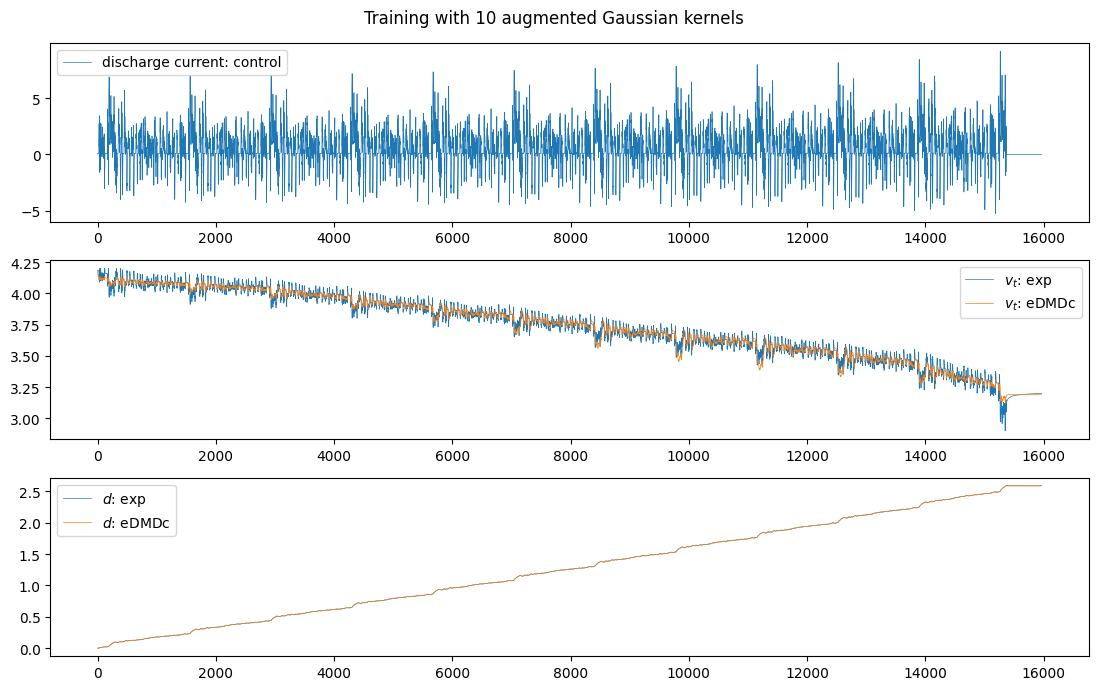

In [6]:
initial_state = state_data[:, 0]

pred_state = simulate_edmdc(Aest, Best, centers, initial_state, control_data[:, :-1])

def compute_prediction_error(pred_state, state_data):
    rms_err = []
    for y, x in zip(pred_state, state_data):
        rms_err.append(np.sqrt(np.average((y - x) ** 2)))
    return rms_err

print("RMS: error:", compute_prediction_error(pred_state, state_data))

lw = 0.5
fig, axs = plt.subplots(len(state_names) + 1, 1, figsize=(11, 7))
axs[0].plot(t_train, control_data[0, :], label="discharge current: control", lw=lw)
axs[0].legend()
for i, ax in enumerate(axs[1:]):
    ax.plot(t_train, state_data[i, :], label=state_names[i] + ": exp", lw=lw)
    ax.plot(t_train, pred_state[i, :], label=state_names[i] + ": eDMDc", lw=lw)
    ax.legend(loc="best")
fig.suptitle("Training with 10 augmented Gaussian kernels")
plt.tight_layout()
plt.show()

### Validation

We can test the models performance on unseen data for validation

RMS: error: [0.05174861678582251, 0.004241528812602336]


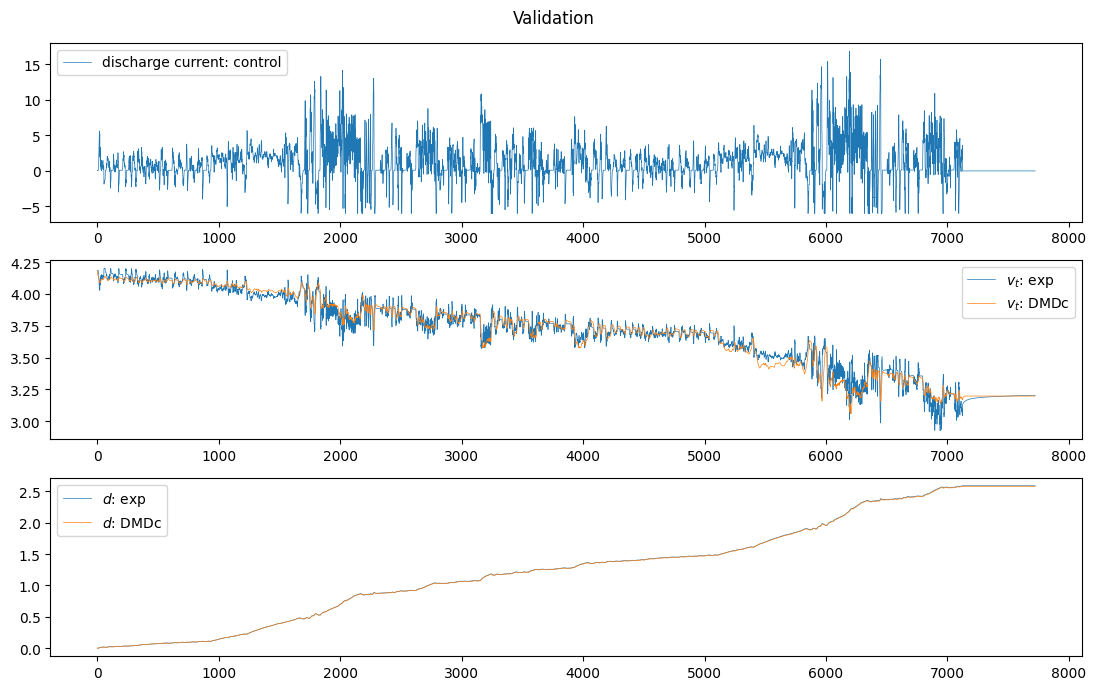

In [7]:
state_data = np.vstack([vt_val, d_val])
control_data = curr_val.reshape((1, curr_val.size))

initial_state = state_data[:, 0]

pred_state = simulate_edmdc(Aest, Best, centers, initial_state, control_data[:, :-1])

print("RMS: error:", compute_prediction_error(pred_state, state_data))

fig, axs = plt.subplots(len(state_names) + 1, 1, figsize=(11, 7))
axs[0].plot(t_val, control_data[0,:], label="discharge current: control", lw=lw)
axs[0].legend()
for i, ax in enumerate(axs[1:]):
    ax.plot(t_val, state_data[i,:], label=state_names[i] + ": exp", lw=lw)
    ax.plot(t_val, pred_state[i,:], label=state_names[i] + ": DMDc", lw=lw)
    ax.legend(loc="best")
fig.suptitle("Validation")
plt.tight_layout()
plt.show()

## Including the eDMDc model in Collimator

To included the extended DMDc model in Collimator, we can modify the `DiscreteLinearSystem` to the `ExtendedDiscreteLinearSystem` and account for the kernel transformations within eDMDc.

In [8]:
import collimator
from collimator.framework import LeafSystem
from collimator.library import Constant

from collimator.simulation import SimulatorOptions, ODESolverOptions

from typing import NamedTuple


class ExtendedDiscreteLinearSystem(LeafSystem):
    """
    System for Extended DMD with control using pykoopman model (Gaussian kernel only)
    """

    def __init__(self, A, B, centers, sigma, dt, initial_state, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.nx_true = initial_state.size

        self.A = A
        self.B = B
        self.nx, self.nu = B.shape
        _, self.n_centers = centers.shape
        self.dt = dt

        self.centers = centers
        self.sigma = sigma

        self.declare_input_port()

        # Generate initial augmented state
        r_sq = jnp.sum((initial_state - self.centers) ** 2, axis=1)
        augmented_states = jnp.exp(-r_sq/ (2.0*self.sigma**2))
        xaug = jnp.hstack([initial_state, augmented_states])

        self.state_index = self.declare_discrete_state(default_value=xaug)

        self.declare_periodic_update(
            self._update_state,
            period=self.dt,
            offset=0.0,
        )

        self.declare_output_port(
            self._eval_output,
            default_value=initial_state,
            period=self.dt,
            offset=0.0,
            requires_inputs=False
        )

    def _eval_output(self, time, state, **params):
        xaug = state.discrete_state
        x_true = xaug[: self.nx_true]
        return x_true

    def _update_state(self, time, state, u, **params):
        xaug = state.discrete_state

        x_true = xaug[: self.nx_true]

        # Re-create the augmented state from the real state
        r_sq = jnp.sum((x_true - self.centers) ** 2, axis=1)
        augmented_states = jnp.exp(-r_sq/ (2.0*self.sigma**2))
        xaug_new = jnp.hstack([x_true, augmented_states])

        y = jnp.matmul(self.A, xaug_new) + jnp.matmul(self.B, jnp.atleast_1d(u))
        return y


class DiscreteSource(LeafSystem):
    class DiscreteStateType(NamedTuple):
        index: jnp.int64
        source_val: jnp.float64

    def __init__(self, val_array, dt, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.val_array = val_array
        self.dt = dt

        self.declare_discrete_state(
            default_value=self.DiscreteStateType(index=0, source_val=val_array[0]),
            as_array=False,
        )

        self.declare_periodic_update(
            self._update,
            period=self.dt,
            offset=0,
        )

        self.declare_output_port(
            self._compute_output,
            default_value=self.val_array[0],
            period=self.dt,
            offset=0.0,
            requires_inputs = False,
        )

    def _compute_output(self, time, state, **params):
        return state.discrete_state.source_val

    def _update(self, time, state, *inputs, **params):
        index = state.discrete_state.index
        index = index + 1
        source_val = self.val_array[index]
        return self.DiscreteStateType(index=index, source_val=source_val)

We can now include the learnt data-driven system in Collimator and simulate.

In [9]:
builder = collimator.DiagramBuilder()
initial_state = jnp.array([vt_train[0], d_train[0]])
dt = 0.1

edls = builder.add(
    ExtendedDiscreteLinearSystem(
        jnp.array(Aest),
        jnp.array(Best),
        jnp.array(centers),
        1.0/jnp.sqrt(2.0),
        dt=dt,
        initial_state=initial_state,
        name="edls",
    )
)

control = builder.add(DiscreteSource(jnp.array(curr_train), dt=dt, name="control"))

builder.connect(control.output_ports[0], edls.input_ports[0])

diagram = builder.build()
context = diagram.create_context()

recorded_signals = {
    "state": diagram["edls"].output_ports[0],
    "control": diagram["control"].output_ports[0],
}

options = SimulatorOptions(max_major_steps=ceil(t_train[-1] / dt))
sol = collimator.simulate(
    diagram,
    context,
    (0.0, t_train[-1]),
    options=options,
    recorded_signals=recorded_signals,
)

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=159656, ode_solver_method=auto, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), Dopri5Solver(system=Diagram(root, 2 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='auto', enable_autodiff=False, supports_mass_matrix=False)


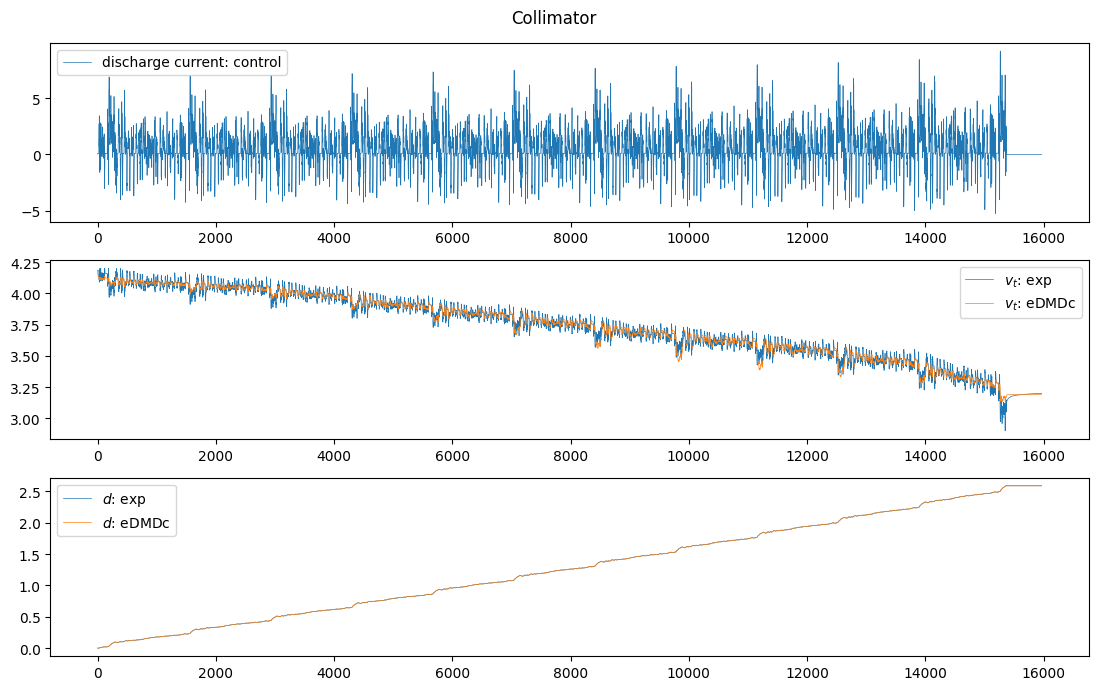

In [10]:
state_data = np.vstack([vt_train, d_train]).T  # exp data for plotting

fig, axs = plt.subplots(len(state_names) + 1, 1, figsize=(11, 7))
axs[0].plot(sol.time, sol.outputs["control"], label="discharge current: control", lw=lw)
axs[0].legend()
for i, ax in enumerate(axs[1:]):
    ax.plot(t_train, state_data[:, i], label=state_names[i] + ": exp", lw=lw)
    ax.plot(
        sol.time, sol.outputs["state"][:, i], label=state_names[i] + ": eDMDc", lw=lw
    )
    ax.legend(loc="best")
fig.suptitle("Collimator")
plt.tight_layout()
plt.show()